![SimPy](http://simpy.readthedocs.io/en/latest/_static/simpy-logo-small.png) 

In [6]:
import simpy

## Short introduction to SimPy

### What is SimPy

SimPy is a _process-based discrete-event simulation **framework**_ for Python.

Other discrete-events software are NS3, NetSim and many others.

### Simulators

Three basic ways to simulate a series of inter-dependent events are:

  - Activity oriented: simulate each small time steps
  - Event oriented: ignore the time in between events (discrete-events).
  - Process based: each activity is simulated as a UNIX process, taking advantage of queues, threads etc offered by the OS.
  
  > SimPy is process-based, but it does not used threads, it instead employes Python _generators_.

## Example

An example of a event is a voice call on a circuit switch network.

### Setup

In [45]:
import random

def expo_delay(mean):
    return random.expovariate(1/mean)

def poisson_arrival(arrival):
    shape = 1
    return random.gammavariate(shape, arrival)

# Assume number of users and tyical traffic per user for voice call
nUsers = 31
User_Traffic_Erlangs = 0.1  # Traffic per user in PSTN (typical)

# Calculate total traffic generate by those users
BH_Erlangs = nUsers * User_Traffic_Erlangs  # Traffic [Erlangs] - dimensioneless

# Assume some duratin for each call (average)
mean_call_duration = 180  # Mean Holding Time (MHT) [sec]

# Calculate the Call Attempt/Arrival for the given traffic (not users!)
BHCA = BH_Erlangs / mean_call_duration # calls attempt during Busy Hour [call/sec]

# This is the average time between calls you should expect
rate_arrival = 1 / BHCA # [sec/call]
print("Busy Hour Traffic: {e}Erlangs (equivalent to {e}hours of call every hour)".format(
        e=BH_Erlangs))
print("Call rate of arrival: {r:.2f}sec/call".format(r=rate_arrival))

Busy Hour Traffic: 3.1Erlangs (equivalent to 3.1hours of call every hour)
Call rate of arrival: 58.06sec/call


In [40]:
import statistics as stats
A = [poisson_arrival(rate_arrival) for i in range(1,1000)]
print("Rate Arrival:  Required: {a:=3.4f}sec/call, Mean {m:=3.4f}sec/call".format(
        a=rate_arrival, 
        m=stats.mean(A)))
D = [expo_delay(mean_call_duration) for i in range(1,1000)]
print("Call Duration: Required: {d:=.4f}sec, Mean {m:=.4f}sec".format(d=mean_call_duration, 
                                                                  m=stats.mean(D)))

Rate Arrival:  Required: 32.2581sec/call, Mean 32.6632sec/call
Call Duration: Required: 100.0000sec, Mean 101.8525sec


### Simulation

Assuming calls are always served (e.g. _resources >> offered traffic_).

Two processes are created:
 * _ring_: alerts of a new call for a user (arrival time is a random process).
 * _talk_: the user talks for a random period before terminating the call. 
 
A _Monitor_ global variable can be used to store variable to be monitored. Note that a python list or ay other _change in place_ container must be used; such that all processes have access to it.

In [9]:
Monitor=[]

def talk(env, call_id):
    """ 
    User locks resources for the duration of the call. 
    """  
    yield env.timeout(expo_delay(mean_call_duration))
    Monitor.append("t={t:=7.2f}s - Caller {id:>3d} terminated call".format(t=env.now, 
                                                                           id=call_id))
    return True
    
def ring(env):
    """
    Call arrival
    """
    call_id = 0
    while True:
        Monitor.append("t={t:=7.2f}s- {ring} - Caller {id:>3d}".format(t=env.now,
                        ring="\033[1;30;41mRing Ring\033[0m", id=call_id))
        env.process(talk(env, call_id))
        yield env.timeout(poisson_arrival(rate_arrival))
        call_id = call_id + 1
    
    
env = simpy.Environment()
env.process(ring(env))
env.run(60*10)

for m in Monitor:
    print(m) 
print("\t...\t...\t...")

t=   0.00s- Ring Ring - Caller   0
t=  14.45s- Ring Ring - Caller   1
t=  72.36s- Ring Ring - Caller   2
t=  86.42s - Caller   1 terminated call
t=  86.49s - Caller   0 terminated call
t= 154.60s- Ring Ring - Caller   3
t= 164.57s- Ring Ring - Caller   4
t= 207.51s - Caller   3 terminated call
t= 265.49s - Caller   4 terminated call
t= 269.34s- Ring Ring - Caller   5
t= 310.03s- Ring Ring - Caller   6
t= 348.42s- Ring Ring - Caller   7
t= 377.57s - Caller   7 terminated call
t= 398.86s- Ring Ring - Caller   8
t= 436.50s- Ring Ring - Caller   9
t= 465.50s - Caller   2 terminated call
t= 486.51s - Caller   5 terminated call
t= 496.88s- Ring Ring - Caller  10
	...	...	...


### A more realistic example: finite resources

Let's assume some finite resources: the system only provide a maximum number of channels, above which no further calls can be served.

SimPy's 'Container' utility are used to pass the number of channels among the _talk_ processes.

In [56]:
'''Set up resources'''
NUMBER_CHANNELS = 8

'''Set up log stores'''
Log = []  # store call events
Monitor = []  # store Channel usage

def talk(env, channels, Log):
    ''' Generator for channel usage
        Only assign channels if there are any available
    '''
    if channels.level > 0:  # check channel avaiability
        channels.get(1)
        yield env.timeout(expo_delay(mean_call_duration))
        channels.put(1)
    else:
        # no resources available... drop the call
        Log.append('drop')
    return True
    
def ring(env, channels, Log):
    ''' Generator for call arrival
        For every new call, call the _talk_ process to serve the call'''
    while True:
        Log.append('call')
        env.process(talk(env, channels, Log))
        yield env.timeout(poisson_arrival(rate_arrival))
        # log status of channels
        Monitor.append((env.now, channels.level))
    
env = simpy.Environment()

# Use simpy containers for tracking resources
channels = simpy.Container(env, capacity=NUMBER_CHANNELS, init=NUMBER_CHANNELS)

env.process(ring(env, channels, Log))
env.run(60 * 60 * 100) 

#### Results

Number calls generated: 6200
Number dropped calls: 58
Call blocking 0.0094


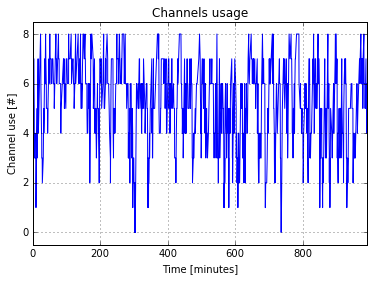

In [55]:
%matplotlib inline

ncalls = len([1 for e in Log if e == 'call'])
ndrop = len([1 for e in Log if e == 'drop'])
print("Number calls generated: {n}".format(n=ncalls))
print("Number dropped calls: {d}".format(d=ndrop))
print("Call blocking {r:2.4f}".format(r=ndrop/ncalls), )

import matplotlib.pyplot as plt

MAX_SMPL = 1000
t = [m[0]/60 for m in Monitor[:MAX_SMPL]]
M = [m[1] for m in Monitor[:MAX_SMPL]]
plt.plot(t,M,'-')
plt.xlabel('Time [minutes]')
plt.ylabel('Channel use [#]')
plt.title('Channels usage')
plt.axis([0,t[-1],-0.5,8.5])
plt.grid(True)
plt.show(True)

The program above only shows a simple example of a classical M/M/k problem; in practice the final result can be calculated from equation (see [Erlang-B](https://en.wikipedia.org/wiki/Erlang_(unit)#Erlang_B_formula)), no simulation would be needed! 

In [35]:
import math
def Blocking_Prob(E, m):
    return ((E**m)/math.factorial(m))/sum((E**i)/math.factorial(i) for i in range(0,m))
    # InvB = 1.0
    # for i in range(1, m+1):
    #     InvB = 1.0 + InvB * i / E
    # return 1.0 / InvB

print("Theoretical drop rate: {d}".format(d=Blocking_Prob(BH_Erlangs, NUMBER_CHANNELS)))

Theoretical drop rate: 0.009666668643494468
